In [306]:
import pandas as pd
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from os.path import join, expanduser, dirname, basename, exists
import pickle
import matplotlib.animation as animation
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation

constant_dir = expanduser('~/Documents/temp/src/functions/constants/')

with open(join(constant_dir, 'sensor_heights.pkl'), 'rb') as f:
    sensor_heights = pickle.load(f)

pd.options.plotting.backend = 'matplotlib'

In [307]:
data_dir = expanduser('~/Documents/temp/data/snowschool/station/')
df = pd.read_csv(join(data_dir,'winter_20_21_clean.csv'), index_col = 0, parse_dates= ['Unnamed: 0'])
units = df.iloc[0]
df = df.iloc[1:]
df.index = pd.to_datetime(df.index)
df = df.tz_convert('US/Mountain')
air_temp_cols = []
for col in df.columns:
    if 'air_temp' in col:
        air_temp_cols.append(col)
    try:
        df[col] = df[col].astype(float)
    except Exception as e:
        print(e)
df.surface_temp_1 = df.surface_temp_1.interpolate()

could not convert string to float: 'NNW'


In [308]:
def plottimeseries(ts_arr, sd_arr, t_arr):
  # Clear the current plot figure
  plt.clf()
  plt.title('Measured Temps')
  plt.ylabel("Heights")
  ax = plt.gca()
  fig = plt.gcf()
  ## put in code to do extent/ticks correctly with t of times
  top = 1.4

  x_lims = pd.Series(t_arr).min(),  pd.Series(t_arr).max()
  x_lims = mdates.date2num(x_lims)
  plt.imshow(ts_arr, extent = (x_lims[0],  x_lims[1], 0, top), aspect = 'auto')
  ax.xaxis_date()
  date_format = mdates.DateFormatter('%D')

  ax.xaxis.set_major_formatter(date_format)

  # This simply sets the x-axis data to diagonal so it fits better.
  fig.autofmt_xdate()

  plt.plot(t_arr, sd_arr, color = 'red', linewidth = 2)
  plt.colorbar()
  
  if pd.Series(sd_arr).max() > 1.4:
    top = pd.Series(sd_arr).max()
  else:
    top = 1.4
  ax.fill_between(t_arr, sd_arr, top, color = 'grey')

  return plt

def prep_arr(arr, old_arr,sd, old_sd, t, old_t):
  heights_temps = {sensor_heights[col]: temp for (col, temp) in arr[air_temp_cols].items() if sensor_heights[col] != 2}
  arr = np.array(list(heights_temps.values())).reshape(len(heights_temps.values()),-1)
  if old_arr is not None:
    ts_arr = np.hstack([old_arr, arr])
  else:
    ts_arr = arr

  if old_sd is not None:
    old_sd.append(sd)
  else:
    old_sd = [sd]
  
  if old_t is not None:
    old_t.append(t)
  else:
    old_t = [t]

  return ts_arr, old_sd, old_t

ts_arr, sd_arr, t_arr = prep_arr(arr = df[air_temp_cols].iloc[0], old_arr = None, sd = df.iloc[0]['snow_depth_1']/1000, old_sd=None, t= df.index[0], old_t = None)

def animate(k):
    global ts_arr, df, sd_arr, t_arr
    sd = df.iloc[k]['snow_depth_1']/1000
    t = df.index[k]
    if k%200 == 0:
          print(k)
    ts_arr, sd_arr, t_arr = prep_arr(df[air_temp_cols].iloc[k], ts_arr, sd = sd, old_sd = sd_arr ,t= t, old_t = t_arr)
    if k!=0:
      plottimeseries(ts_arr, sd_arr, t_arr)
    else:
      ts_arr, sd_arr, t_arr = prep_arr(df[air_temp_cols].iloc[k], ts_arr, sd = sd, old_sd = sd_arr ,t= t, old_t = t_arr)

MovieWriter ffmpeg unavailable; using Pillow instead.


0
0
50
100
150
200


KeyboardInterrupt: 

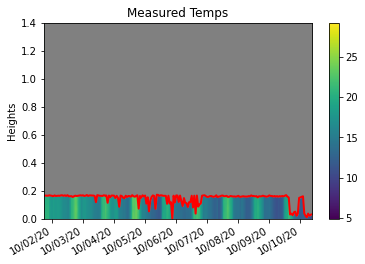

In [310]:
ts_arr, sd_arr, t_arr = None, None, None
anim = animation.FuncAnimation(plt.figure(), animate, interval=0.3, frames=df.air_temp_10.size, repeat=False)
anim.save("temp_time_series_hourly.gif")

In [311]:
df = df.resample('D').mean()

In [395]:
ts_arr, sd_arr, t_arr, air_arr = None, None, None, None

def plottimeseries(ts_arr, sd_arr, t_arr, air_arr):
  # Clear the current plot figure
  plt.clf()
  plt.ylabel("Heights")
  ax = plt.gca()
  fig = plt.gcf()
  ## put in code to do extent/ticks correctly with t of times
  top = 1.4

  x_lims = pd.Series(t_arr).min(),  pd.Series(t_arr).max()
  x_lims = mdates.date2num(x_lims)
  plt.imshow(ts_arr, extent = (x_lims[0],  x_lims[1], 0, top), aspect = 'auto', interpolation= 'gaussian', vmax = 5, vmin = -10)
  ax.xaxis_date()
  date_format = mdates.DateFormatter('%D')

  ax.xaxis.set_major_formatter(date_format)

  # This simply sets the x-axis data to diagonal so it fits better.
  fig.autofmt_xdate()

  plt.plot(t_arr, sd_arr, color = 'red', linewidth = 2)
  plt.colorbar(label = 'Temps $\degree$ C')
  
  if pd.Series(sd_arr).max() > 1.4:
    top = pd.Series(sd_arr).max()
  else:
    top = 1.4

  ax.fill_between(t_arr, sd_arr, top, color = 'grey')
  ax.set_facecolor('grey')

  ax2 = fig.add_axes([0.125 ,0.9,0.62,0.1])
  air_arr = np.array(air_arr)
  ax2.imshow(air_arr.reshape(-1, air_arr.size), extent = (x_lims[0],  x_lims[1], 0, 1), aspect= 'auto', vmax = 5, vmin = -10)
  ax2.set_axis_off()
  ax2.set_ylabel('Free Air')

  plt.title('Measured Temps')

  return plt

def prep_arr(arr, old_arr,sd, old_sd, t, old_t, old_air):
  heights_temps = {sensor_heights[col]: temp for (col, temp) in arr[air_temp_cols].items() if sensor_heights[col] != 2}
  air_temp = arr['air_temp_1']
  arr = np.array(list(heights_temps.values())).reshape(len(heights_temps.values()),-1)

  if old_arr is not None:
    ts_arr = np.hstack([old_arr, arr])
  else:
    ts_arr = arr
  
  if old_air is not None:
    old_air.append(air_temp)
  else:
    old_air = [air_temp]

  if old_sd is not None:
    old_sd.append(sd)
  else:
    old_sd = [sd]
  
  if old_t is not None:
    old_t.append(t)
  else:
    old_t = [t]

  return ts_arr, old_sd, old_t, old_air

ts_arr, sd_arr, t_arr, air_arr = prep_arr(arr = df[air_temp_cols].iloc[0], old_arr = None, sd = df.iloc[0]['snow_depth_1']/1000, old_sd=None, t= df.index[0], old_t = None, old_air = air_arr)

def animate(k):
    global ts_arr, df, sd_arr, t_arr, air_arr
    sd = df.iloc[k]['snow_depth_1']/1000
    t = df.index[k]
    if k%50 == 0:
          print(k)
    ts_arr, sd_arr, t_arr, air_arr = prep_arr(df[air_temp_cols].iloc[k], ts_arr, sd = sd, old_sd = sd_arr ,t= t, old_t = t_arr, old_air = air_arr)
    
    if k!=0:
      plottimeseries(ts_arr, sd_arr, t_arr, air_arr)
    else:
      ts_arr, sd_arr, t_arr, air_arr = prep_arr(df[air_temp_cols].iloc[k], ts_arr, sd = sd, old_sd = sd_arr ,t= t, old_t = t_arr, old_air = air_arr)

0
0
50
100
150
200


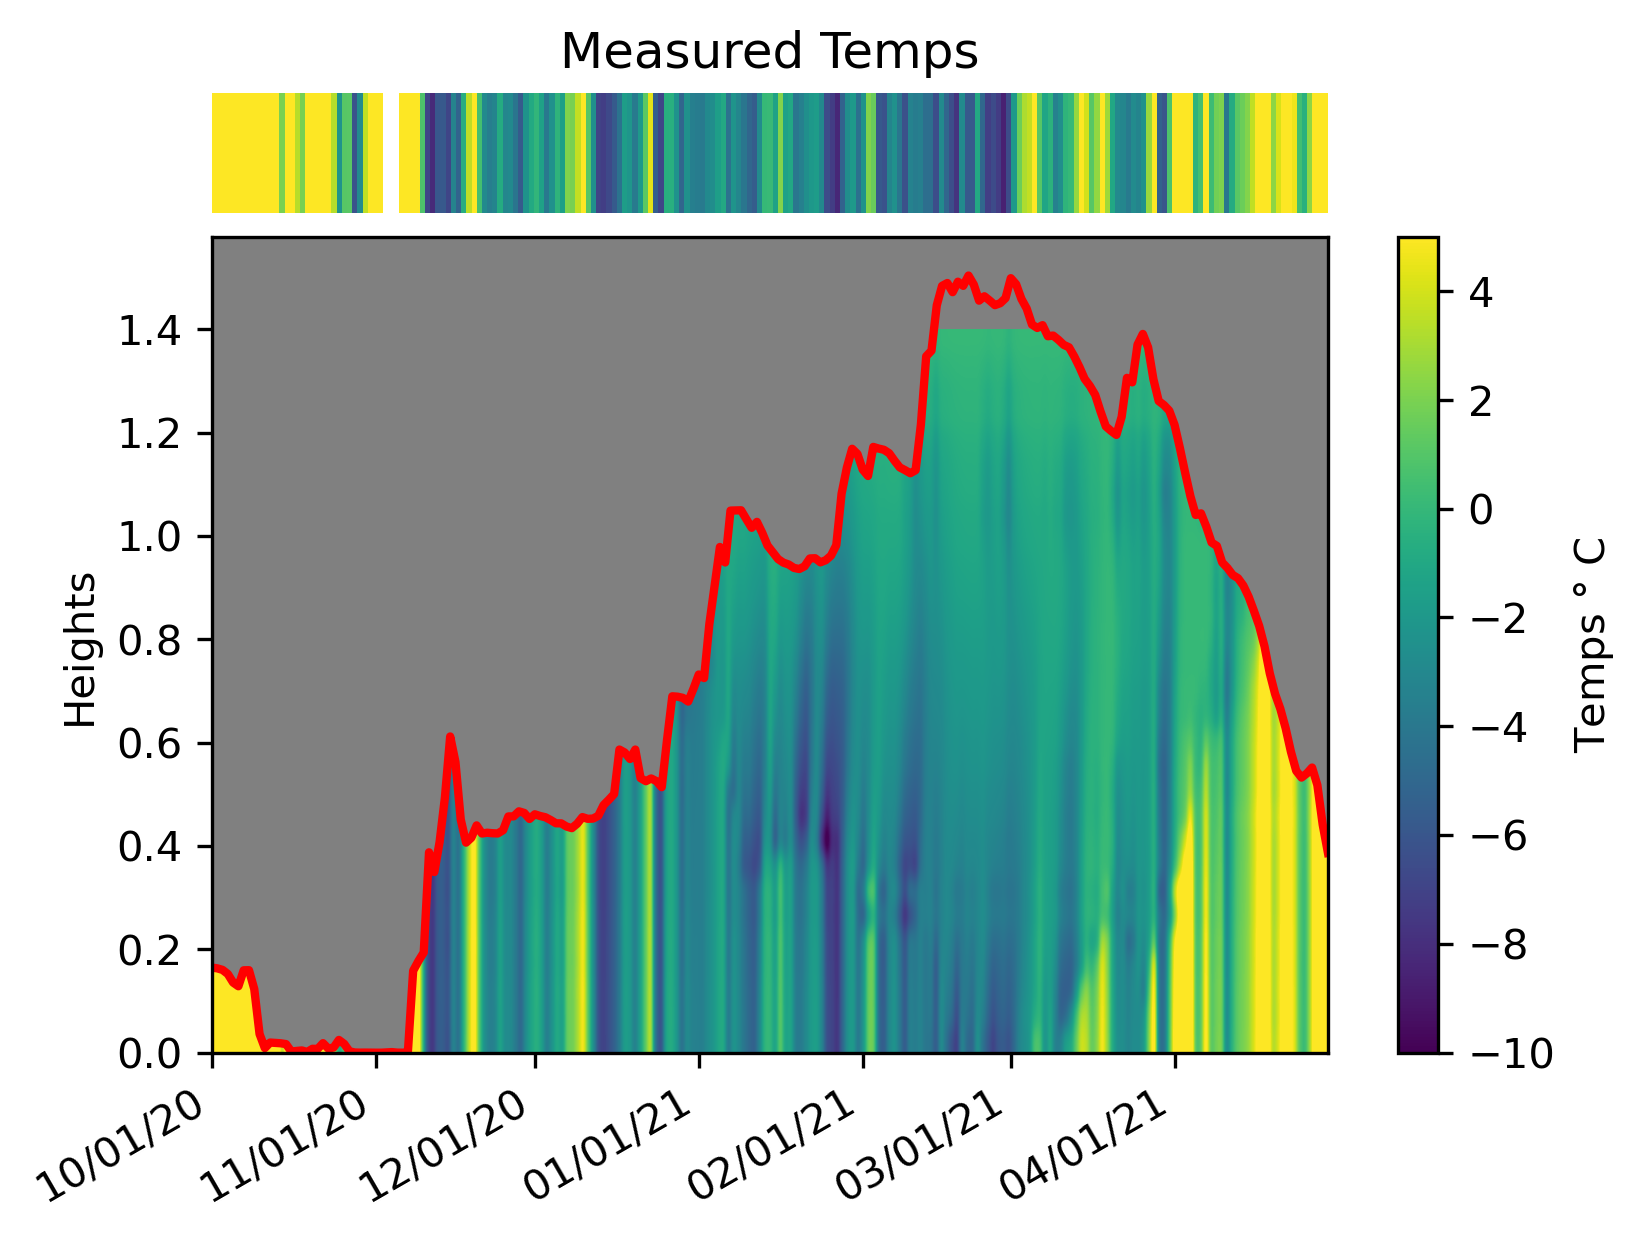

In [396]:
ts_arr, sd_arr, t_arr, air_arr = None, None, None, None
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, bitrate=900) #<-- increase bitrate
frames = df.air_temp_10.size
# frames = 10
anim = animation.FuncAnimation(plt.figure(dpi = 300), animate, interval=1, frames=frames, repeat=False)
anim.save("temp_time_series_daily.gif", writer=writer, dpi = 300)

# Play Below

/var/folders/0n/swn__wf94qd3zdch1tvp087r0000gn/T/ipykernel_19385/2666702595.py:9: UserWarning: Attempting to set identical left == right == 18536.25 results in singular transformations; automatically expanding.
  plt.imshow(ts_arr, extent = (x_lims[0],  x_lims[1], 0, top), aspect = 'auto')
/var/folders/0n/swn__wf94qd3zdch1tvp087r0000gn/T/ipykernel_19385/2666702595.py:23: UserWarning: Attempting to set identical left == right == 18536.25 results in singular transformations; automatically expanding.
  ax2.imshow(air_arr.reshape(-1, air_arr.size),extent = (x_lims[0],  x_lims[1], top, top +0.1), aspect= 'auto', vmax = 5, vmin = -15)


Text(0.5, 1.0, 'Measured Temps')

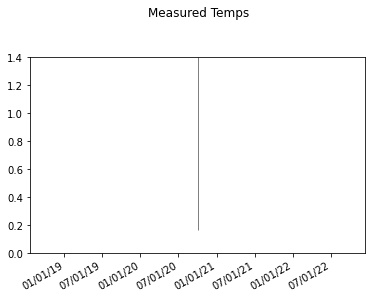

In [375]:
fig,ax = plt.subplots()
if pd.Series(sd_arr).max() > 1.4:
    top = pd.Series(sd_arr).max()
else:
    top = 1.4

x_lims = pd.Series(t_arr).min(),  pd.Series(t_arr).max()
x_lims = mdates.date2num(x_lims)
plt.imshow(ts_arr, extent = (x_lims[0],  x_lims[1], 0, top), aspect = 'auto')
ax.xaxis_date()
date_format = mdates.DateFormatter('%D')

ax.xaxis.set_major_formatter(date_format)

# This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()

plt.plot(t_arr, sd_arr, color = 'red')
ax.fill_between(t_arr, sd_arr, top, color = 'grey')

ax2 = fig.add_axes([0.125 ,0.9,0.78,0.1])
air_arr = np.array(air_arr)
ax2.imshow(air_arr.reshape(-1, air_arr.size),extent = (x_lims[0],  x_lims[1], top, top +0.1), aspect= 'auto', vmax = 5, vmin = -15)
ax2.set_axis_off()
plt.title('Measured Temps')

In [ ]:
ax.set_axis_off

In [346]:
?fig.add_axes

Signature: fig.add_axes(*args, **kwargs)
Docstring:
Add an Axes to the figure.

Call signatures::

    add_axes(rect, projection=None, polar=False, **kwargs)
    add_axes(ax)

Parameters
----------
rect : sequence of float
    The dimensions [left, bottom, width, height] of the new Axes. All
    quantities are in fractions of figure width and height.

projection : {None, 'aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear', str}, optional
    The projection type of the `~.axes.Axes`. *str* is the name of
    a custom projection, see `~matplotlib.projections`. The default
    None results in a 'rectilinear' projection.

polar : bool, default: False
    If True, equivalent to projection='polar'.

axes_class : subclass type of `~.axes.Axes`, optional
    The `.axes.Axes` subclass that is instantiated.  This parameter
    is incompatible with *projection* and *polar*.  See
    :ref:`axisartist_users-guide-index` for examples.

sharex, sharey : `~.axes.Axes`, optional
    Shar

0
0


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fbbdd3c1820>
Traceback (most recent call last):
  File "/Users/zachkeskinen/miniconda3/envs/snow_temps/lib/python3.9/site-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


50
100
150


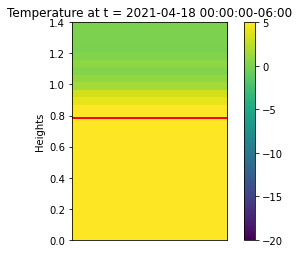

In [338]:
def plotheatmap(temp_profile, t, sd):
  # Clear the current plot figure
  plt.clf()
  plt.title(f"Temperature at t = {t}")
  plt.ylabel("Heights")
  
  # This is to plot u_k (u at time-step k)
  heights_temps = {sensor_heights[col]: temp for (col, temp) in temp_profile[air_temp_cols].items() if sensor_heights[col] != 2}
  arr = np.array(list(heights_temps.values())).reshape(len(heights_temps.values()),-1)

  plt.imshow(arr, extent= [0,1,0,1.4], vmin = -20, vmax = 5)
  plt.axhline(sd, color = 'red', linewidth = 2)
  plt.xticks([])
  plt.colorbar()
  
  return plt
max_iter_time = 200
def animate(k):
    if k%50 == 0:
        print(k)
    plotheatmap(df[air_temp_cols].iloc[k], df.index[k], df.iloc[k]['snow_depth_1']/1000)

anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False)
anim.save("heat_equation_solution.gif")